<a href="https://colab.research.google.com/github/rizkyprofs/ML_DL/blob/main/DLWeek7_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import keras_tuner as kt

In [ ]:
# Load data
file_path = 'ReviewTokoBaju.csv'
data = pd.read_csv(file_path, engine='python', on_bad_lines='skip')

# Ambil Review Text dan Label
sentences = data['Review Text'].dropna().values
labels = data.loc[data['Review Text'].notna(), 'Recommended IND'].values

# Tokenization
vocab_size = 10000
max_length = 100
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)


## Training Model

In [ ]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embed_dim', 32, 128, step=32),
        input_length=max_length
    ))
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.SimpleRNN(
            units=hp.Int('rnn_units', 32, 128, step=32),
            dropout=hp.Choice('dropout_rate', [0.2, 0.3, 0.5])
        )
    ))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(hp.Choice('lr', [1e-3, 1e-4])),
        metrics=['accuracy']
    )
    return model

# Tuning Hyperparameter
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=1,
    directory='bidir_rnn_tuner',
    project_name='review_toko_baju'
)

tuner.search(X_train, y_train, epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 5 Complete [00h 04m 11s]
val_accuracy: 0.8385316133499146

Best val_accuracy So Far: 0.8804857730865479
Total elapsed time: 00h 18m 03s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 20 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Evaluasi

Epoch 1/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 60s 94ms/step - accuracy: 0.9077 - loss: 0.2329 - val_accuracy: 0.8885 - val_loss: 0.2729
Epoch 2/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 74s 81ms/step - accuracy: 0.9188 - loss: 0.2054 - val_accuracy: 0.8929 - val_loss: 0.2596
Epoch 3/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 47s 83ms/step - accuracy: 0.9314 - loss: 0.1806 - val_accuracy: 0.8841 - val_loss: 0.2682
Epoch 4/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 45s 79ms/step - accuracy: 0.9416 - loss: 0.1560 - val_accuracy: 0.8867 - val_loss: 0.2753
Epoch 5/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 82s 79ms/step - accuracy: 0.9513 - loss: 0.1374 - val_accuracy: 0.8874 - val_loss: 0.2880
Epoch 6/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 83s 81ms/step - accuracy: 0.9600 - loss: 0.1110 - val_accuracy: 0.8883 - val_loss: 0.3087
Epoch 7/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.9654 - loss: 0.0955 - val_accuracy: 0.8821 - val_loss: 0.3385
Epoch 8/10
566/566 ━━━━━━━━━━━━━━━━━━━━ 84s 82ms/step - accuracy: 0.9736 - loss: 0.0779 - 

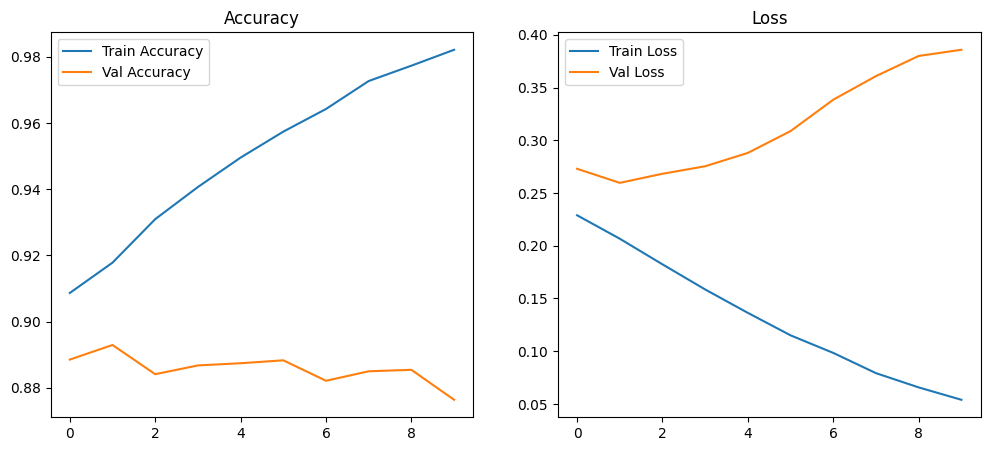

142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Akurasi  : 0.8764
Presisi  : 0.9138
Recall   : 0.9379
F1-Score : 0.9257
AUC      : 0.8910


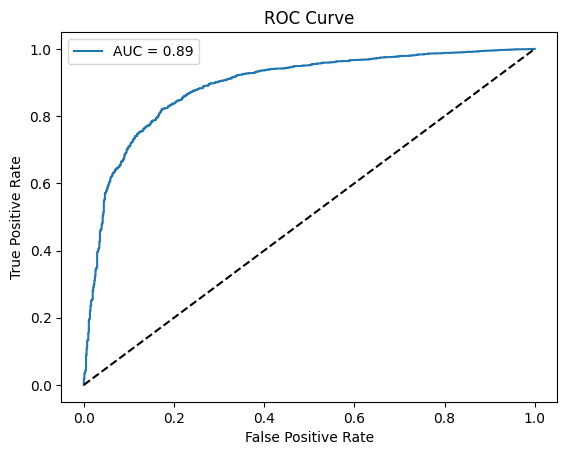

In [ ]:
# Training model terbaik
history = best_model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

# Visualisasi Akurasi dan Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()

# Evaluasi Model
y_pred_prob = best_model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print(f"Akurasi  : {acc:.4f}")
print(f"Presisi  : {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-Score : {f1:.4f}")
print(f"AUC      : {auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()
